### **---------------------------------- EXPERIMENTS ----------------------------------------**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
import sys

from nnet_tensorflow_submitted import *

%load_ext autoreload
%autoreload 2

def main_create_params(varying_params):
    # extract varying parameters
    width = varying_params['width']  
    maxIter = int(varying_params['maxIter'])
  
    # parameters
    output_schedule = np.array([*np.arange(10,100,10), *np.arange(100,1000,100), \
                                *np.arange(1e3,1e4,1e3), *np.arange(1e4,1e5,1e4), \
                                *np.arange(1e5,1e6,1e5), 1e6, 15, 15e1, 15e2, 15e3, 15e4]).astype(int)
    output_schedule = np.sort(output_schedule)                    
    output_schedule = output_schedule[output_schedule<=maxIter]    
    savemodel_schedule = np.array([])  
    savemodel_schedule = savemodel_schedule[savemodel_schedule<=maxIter]
    save_prediction_schedule = output_schedule    
    subsample_schedule = np.array([]) 
  
    depth = 3
    params = dict(    
        neural_net = dict(
            loss_choice = 'huber',
            transfer_func = ['tanh']*(depth-1) + ['linear'],
            layer_dim = [[28*28, width]] + [[width, width]]*(depth-2) + [[width, 1]],
            W_init = dict(
                scheme = 'Gaussian',
                params = dict(
                    mean = [0.0] + [0.1]*(depth-1),
                    std = [1.0] + [1.0]*(depth-1),
                )
            ),
            GPU_which = 0,
            GPU_memory_fraction = 0.99,
            show_device = True,
            Tensorflow_randomSeed = 1,
            dtype = tf.float32
        ),
        data = dict(
            dataDim = [28, 28, 1],
            data_choice = 'mnist', 
            data_structure = dict(
                classes = [[0, 4], [5, 9]],
                labels = np.array([-1.0, 1.0], dtype=np.float32),
                number_training_samples = 100
            ),
            Numpy_randomSeed = 1
        ),
        SGD = dict(
            iteration_num = maxIter,
            stepSize = 7e-3,
            batchSize = 100
        ),
        statsCollect = dict(
            output_schedule = output_schedule,
            numMonteCarlo = 10000,
            savemodel_schedule = savemodel_schedule,
            savemodel_path = './',
            savemodel_header = 'mnist_model_' + str(width),
            save_prediction_schedule = save_prediction_schedule,
            subsample_schedule = subsample_schedule,
            subsample_params = dict(
                sample_sizes = [50, 100, 200, 400],
                seeds = range(10)  
            ),
            is_verbose = False
        )
    )

    return params


def main_run_experiment(params, verbose=True):
    # run experiments
    start_time = time.time()
    obj = nnet_simul(params)
    obj.run()  
    stats = obj.collect_stats()  
    elapsed_min = (time.time() - start_time)/60     

    # print final results
    if verbose:
      lastIter = np.max(params['statsCollect']['output_schedule'])
      print('Taken ' + str(elapsed_min) + ' minutes. Test error = ' + str(obj.stats[lastIter]['error_test']) + 
          '. Test loss = ' + str(obj.stats[lastIter]['loss_test']))

    return obj, elapsed_min


def write_pickle(obj, path):
    with open(path, 'wb') as handle:
        pickle.dump(obj, handle)


def read_pickle(path):
    with open(path, 'rb') as handle:
        ans = pickle.load(handle)
    return ans

def load_model_nnet_simul(path, params):
  obj = nnet_simul(params)
  obj.generate_nnet()
  obj.load_model(path)
  return obj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




---





---





---





---





---



# Loss evolution

... Running with width = 50
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

11493376/11490434 [==============================] - 0s 0us/step
Taken 2.815405205885569 minutes. Test error = 0.15402536888428683. Test loss = 0.20459117369117313


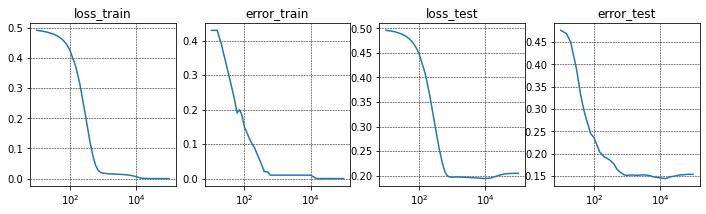

... Running with width = 100
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Taken 2.7043876091639203 minutes. Test error = 0.15350763655190267. Test loss = 0.20360385295781885


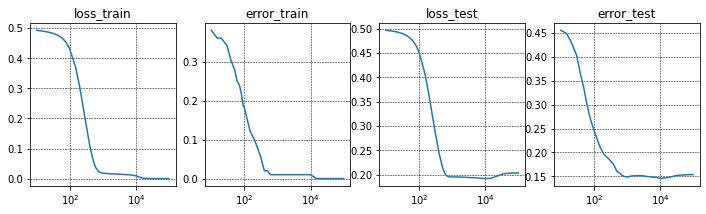

... Running with width = 200
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Taken 2.743987174828847 minutes. Test error = 0.1516955733885581. Test loss = 0.20101862089284614


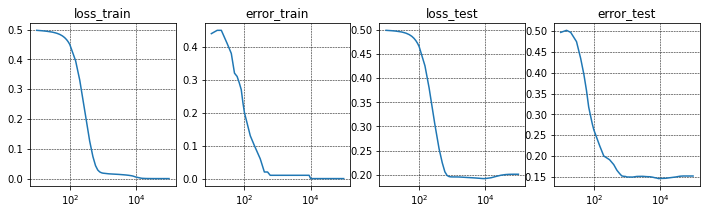

... Running with width = 400
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Taken 2.789380351702372 minutes. Test error = 0.1542842350504789. Test loss = 0.2045327861507168


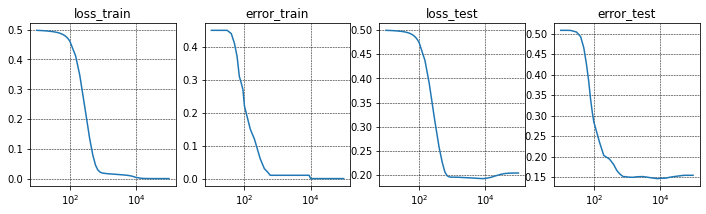

In [ ]:
Nvals = [50, 100, 200, 400]

for N in Nvals:
  print('... Running with width = ' + str(N))
  varying_params = {'width': N, 'maxIter': 1e5}
  params = main_create_params(varying_params)
  obj, elapsed_min = main_run_experiment(params)
  obj.plot_evolution()
  write_pickle(obj.collect_stats(), os.path.join(ROOT_DIR, 'mnist0459_stats_' + str(N) + '.pickle'))

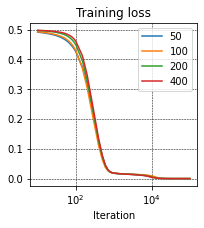

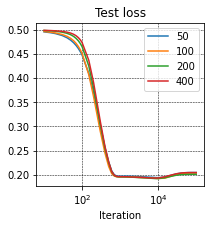

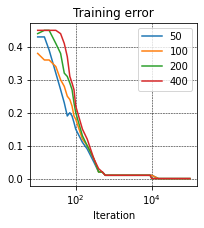

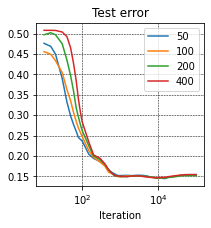

In [ ]:
Nvals = [50, 100, 200, 400]

whichs = ['loss_train', 'loss_test', 'error_train', 'error_test']
ylabels = ['Training loss', 'Test loss', 'Training error', 'Test error']

for cnt, which in enumerate(whichs):
  plt.figure(figsize=(3,3))
  for N in Nvals:
    stats = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_stats_' + str(N) + '.pickle'))    
    s = []
    for i in sorted(stats.keys()):
      s.append(stats[i][which])
    plt.semilogx(sorted(stats.keys()), s)
  plt.legend(Nvals)
  plt.grid(color='k', linestyle='--', linewidth=0.5) 
  plt.xlabel('Iteration')
  plt.title(ylabels[cnt])
  plt.show()


---


---

# Output variance from random initialization

In [ ]:
M = 10
Nvals = [50, 100, 200, 400]

for N in Nvals:
  print('... Running with width = ' + str(N))
  for cnt in range(M):
    varying_params = {'width': N, 'maxIter': 1e5}
    params = main_create_params(varying_params)
    params['statsCollect']['output_schedule'] = [1, 1e5]
    params['neural_net']['Tensorflow_randomSeed'] = cnt
    params['neural_net']['show_device'] = False

    obj, elapsed_min = main_run_experiment(params, verbose=False)

    if cnt==0:
      print('1 run takes ' + str(elapsed_min) + ' minutes')
    sys.stdout.write("\r{0}%".format((cnt+1)/M*100.0))
    sys.stdout.flush()
    
    write_pickle(obj.get_trainpred(), os.path.join(ROOT_DIR, 'mnist0459_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
  print('\n')

... Running with width = 50
1 run takes 2.53915753364563 minutes
100.0%

... Running with width = 100
1 run takes 2.591709824403127 minutes
100.0%

... Running with width = 200
1 run takes 2.634581816196442 minutes
100.0%

... Running with width = 400
1 run takes 2.6382755478223165 minutes
100.0%



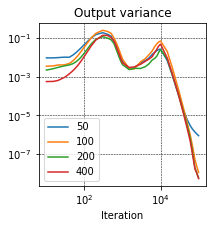

In [ ]:
M = 10
Nvals = [50, 100, 200, 400]

plt.figure(figsize=(3,3))
for N in Nvals:
  # compute average
  avg = {}
  for cnt in range(M):
    pred = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
    iters = list(pred.keys())
    if cnt==0:
      for cnt_it in range(len(iters)):
        it = iters[cnt_it]
        avg[it] = pred[it]['pred']/M
    else:
      for cnt_it in range(len(iters)):
        it = iters[cnt_it]
        avg[it] = avg[it] + pred[it]['pred']/M

  # compute variance
  var = np.zeros(len(iters))
  for cnt in range(M):
    pred = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
    for cnt_it in range(len(iters)):
      it = iters[cnt_it]
      var[cnt_it] = var[cnt_it] + np.mean((pred[it]['pred'] - avg[it])**2)*N
  var = var/M

  plt.loglog(iters, var)

plt.legend(Nvals)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title('Output variance')
plt.xlabel('Iteration')
plt.show()



---





---





---





---



# Output fluctuation histogram



Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Visualize the test sample:


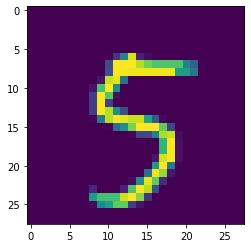

... Running with width = 50
1 run takes 0.051597416400909424 minutes
100.0%

... Running with width = 100
1 run takes 0.048791146278381346 minutes
100.0%

... Running with width = 200
1 run takes 0.05156848430633545 minutes
100.0%

... Running with width = 400
1 run takes 0.05177666743596395 minutes
100.0%



In [ ]:
M = 1000
Nvals = [50, 100, 200, 400]
lastIter = 1e3

# get a test point
params = main_create_params({'width': 100, 'maxIter': lastIter})
params['neural_net']['Numpy_randomSeed'] = 1
obj = nnet_simul(params)
obj.generate_nnet()
x_test, y_test, id_test = obj.generate_data(1, 'test')
print('Visualize the test sample:')
plt.imshow(x_test[0,:,:,0])
plt.show()

# run job
for N in Nvals:
  res = []
  print('... Running with width = ' + str(N))
  for cnt in range(M):
    params = main_create_params({'width': N, 'maxIter': lastIter})
    params['statsCollect']['output_schedule'] = [1, lastIter]
    params['statsCollect']['save_prediction_schedule'] = []
    params['neural_net']['Tensorflow_randomSeed'] = cnt
    params['neural_net']['show_device'] = False
    obj, elapsed_min = main_run_experiment(params, verbose=False)
    if cnt==0:
      print('1 run takes ' + str(elapsed_min) + ' minutes')
    sys.stdout.write("\r{0}%".format((cnt+1)/M*100.0))
    sys.stdout.flush()
    y = obj.predict(x_test)[0][0]
    res.append(y)
  print('\n')
  write_pickle(res, os.path.join(ROOT_DIR, 'mnist0459_hist_' + str(N) + '_iter' + str(int(lastIter)) + '.pickle'))

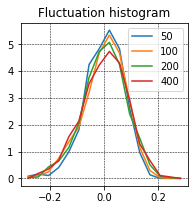

In [ ]:
# plot training histogram

plt.figure(figsize=(3,3))
for N in [50, 100, 200, 400]:
  res = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_hist_' + str(N) + '_iter1000.pickle'))
  res = (res - np.mean(res))*np.sqrt(N)
  y, bin_edges = np.histogram(res, bins=np.linspace(-0.3,0.3,17), density=True)   
  bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
  plt.plot(bin_centers, y)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend([50, 100, 200, 400])
plt.title('Fluctuation histogram')
plt.xlabel('Iteration', color='w')
plt.show()


---


---

# Output variance at global opt

... Running with width = 5000
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Taken 9.857797439893087 minutes. Test error = 0.15273103805332644. Test loss = 0.20205898090730268


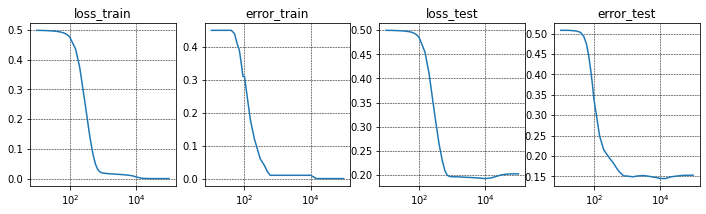

In [ ]:
N = 5000
print('... Running with width = ' + str(N))
varying_params = {'width': N, 'maxIter': 1e5}
params = main_create_params(varying_params)
params['statsCollect']['savemodel_schedule'] = [1e5]
obj, elapsed_min = main_run_experiment(params)
obj.plot_evolution()
obj_inf = obj

In [ ]:
varying_params = {'width': 5000, 'maxIter': 1e5}
params = main_create_params(varying_params)
obj_inf = load_model_nnet_simul('./mnist_model_5000__100000', params)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

INFO:tensorflow:Restoring parameters from ./mnist_model_5000__100000


In [ ]:
M = 10
Nvals = [50, 100, 200, 400]

W_inf = obj_inf.get_weights()
print('Shape of W_inf: ', W_inf[0].shape, W_inf[1].shape, W_inf[2].shape)

for N in Nvals:
  
  print('... Running with width = ' + str(N))
  for cnt in range(M):
    rng = np.random.default_rng(cnt)
    samples1 = rng.integers(low=0, high=W_inf[0].shape[1], size=N)
    samples2 = rng.integers(low=0, high=W_inf[0].shape[1], size=N)
    W_samples = [W_inf[0][:, samples1], 
                W_inf[1][samples1, :][:, samples2], 
                W_inf[2][samples2, :]]

    varying_params = {'width': N, 'maxIter': 1e5}
    params = main_create_params(varying_params)
    params['statsCollect']['output_schedule'] = [1, 1e5]
    params['neural_net']['Tensorflow_randomSeed'] = cnt
    params['neural_net']['show_device'] = False
    params['neural_net']['W_init']['scheme'] = 'external'
    params['neural_net']['W_init']['overload'] = W_samples

    obj, elapsed_min = main_run_experiment(params, verbose=False)

    if cnt==0:
      print('1 run takes ' + str(elapsed_min) + ' minutes')
    sys.stdout.write("\r{0}%".format((cnt+1)/M*100.0))
    sys.stdout.flush()
    
    write_pickle(obj.get_trainpred(), os.path.join(ROOT_DIR, 'mnist0459_subsampled_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
  print('\n')


Shape of W_inf:  (785, 5000) (5000, 5000) (5000, 1)
... Running with width = 50
1 run takes 2.597308321793874 minutes
100.0%

... Running with width = 100
1 run takes 2.6043829202651976 minutes
100.0%

... Running with width = 200
1 run takes 2.5946513851483664 minutes
100.0%

... Running with width = 400
1 run takes 2.6620940963427224 minutes
100.0%



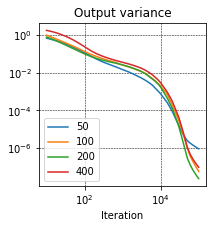

In [ ]:
M = 10
Nvals = [50, 100, 200, 400]

plt.figure(figsize=(3,3))
for N in Nvals:
  # compute average
  avg = {}
  for cnt in range(M):
    pred = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_subsampled_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
    iters = list(pred.keys())
    if cnt==0:
      for cnt_it in range(len(iters)):
        it = iters[cnt_it]
        avg[it] = pred[it]['pred']/M
    else:
      for cnt_it in range(len(iters)):
        it = iters[cnt_it]
        avg[it] = avg[it] + pred[it]['pred']/M

  # compute variance
  var = np.zeros(len(iters))
  for cnt in range(M):
    pred = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_subsampled_' + str(N) + '_seed' + str(cnt) + '_trainpred.pickle'))
    for cnt_it in range(len(iters)):
      it = iters[cnt_it]
      var[cnt_it] = var[cnt_it] + np.mean((pred[it]['pred'] - avg[it])**2)*N
  var = var/M

  plt.loglog(iters, var)

plt.legend(Nvals)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title('Output variance')
plt.xlabel('Iteration')
plt.show()


---


---


---


---

# MC output variance

... Running with width = 5000
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Taken 14.34828242858251 minutes. Test error = 0.15273103805332644. Test loss = 0.20205896917692961


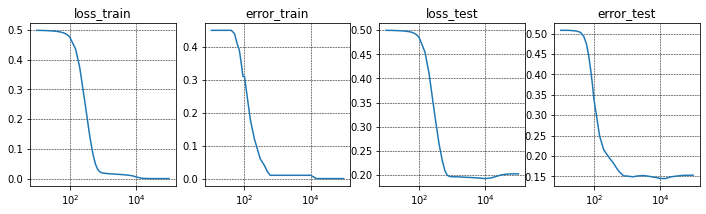

In [ ]:
N = 5000
lastIter = 1e5
print('... Running with width = ' + str(N))
varying_params = {'width': N, 'maxIter': lastIter}
params = main_create_params(varying_params)
params['statsCollect']['subsample_schedule'] = np.array([*np.arange(10,100,10), *np.arange(100,1000,100), \
                                *np.arange(1e3,1e4,1e3), *np.arange(1e4,1e5,1e4), \
                                *np.arange(1e5,1e6,1e5), 1e6, 15, 15e1, 15e2, 15e3, 15e4]).astype(int)
params['statsCollect']['save_prediction_schedule'] = np.array([])
obj, elapsed_min = main_run_experiment(params)
obj.plot_evolution()

write_pickle(obj.get_subsample_results(), os.path.join(ROOT_DIR, 'mnist0459_subsample_infN' + str(N) + '_iter' + str(int(lastIter)) + '.pickle'))

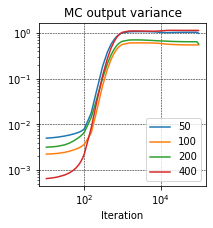

In [ ]:
Nvals = [50, 100, 200, 400]
res = read_pickle(os.path.join(ROOT_DIR, 'mnist0459_subsample_infN5000_iter100000.pickle'))
iters = list(res.keys())

plt.figure(figsize=(3,3))
for N in Nvals:
  seeds = list(res[iters[0]][N].keys())
  M = len(seeds)

  # compute average
  avg = {}
  for seed in seeds:
    if seed==seeds[0]:
      for it in iters:
        avg[it] = res[it][N][seed]['pred_train']/M
      else:
        avg[it] = avg[it] + res[it][N][seed]['pred_train']/M

  # compute variance
  var = np.zeros(len(iters))
  for seed in seeds:
    for cnt_it in range(len(iters)):
      it = iters[cnt_it]
      var[cnt_it] = var[cnt_it] + np.mean((res[it][N][seed]['pred_train'] - avg[it])**2)*N
  var = var/M

  plt.loglog(iters, var)

plt.legend(Nvals)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title('MC output variance')
plt.xlabel('Iteration')
plt.show()